This notebook is for defining and applying two supervised learning methods: support vector machine (SVM) and Random Forest. Model inputs include data from both areas of interest: Koumassi and Southeast. Files to be included in model were labled with "raw" in the calculating_spectral_indices notebooks. Model inputs were determined based on earlier explorations and include the following 8 parameters: 
- "Dark" parameter: sum of red-edge, NIR1, and NIR2 bands
- Morphological building index (MBI)
- Morphological shadow index (MSI)
- Normalized difference vegetation index (NDVI)
- Normalized difference water index (coastal/NIR2, NDWI)
- NDWIcoastal/NIR2 - MSI (difference)
- Normalized difference water index (yellow/NIR2, NDWI)
- NDWIyellow/NIR2 - MSI (difference)


*Note that some cells have been commented out after the best model had been saved to avoid over-writing.



## Currently working on implementing new functions for plotting confusion matrices and reporting errors of commission/omission and users/producers accuracy

In [1]:
# Import necessary packages
import os
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
import earthpy as et
import earthpy.spatial as es

# Import modules with custom functions
import sys
sys.path.insert(0, '..\\modules\\')
import confusion_matrix_plus
import validation

In [2]:
# Define areas of interest and paths
aoi = 'koumassi_focus_ps'
koumassi_band_path = '..\\data\\'+aoi+"\\"
koumassi_raster_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\raster_files\\")
koumassi_svm_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\svm\\")

aoi2 = 'southeast_ps'
southeast_band_path = '..\\data\\'+aoi2+"\\"
southeast_raster_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\raster_files\\")
southeast_svm_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\svm\\")

# Check for and/or create combined folder
combined_svm_outputs_path = '..\\data\\combined\\'
try:
    os.makedirs(combined_svm_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

# Select all raw index/band value tif files needed for model inputs
# Files to be included in model were labled with "raw" in the calculating_spectral_indices notebooks
koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
koumassi_raw_list.sort()
southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
southeast_raw_list.sort()

band_path directory already exists!


In [3]:
# Set paths for validation data inputs
validation_data_path = os.path.join('..\\data\\combined\\validation\\')
koumassi_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_koumassi.shp")
southeast_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_southeast.shp")

In [4]:
# Get meta data for writing out SVM result
koumassi_all_bands_path = os.path.join(
    koumassi_raster_outputs_path + aoi+"_all_bands.tif")
with rio.open(koumassi_all_bands_path) as src:
    koumassi_all_bands_stack = src.read()
    stack_meta = src.meta
    koumassi_files_out_meta = src.meta.copy()
koumassi_files_out_meta['count'] = 1


# Get meta data for writing out SVM result
southeast_all_bands_path = os.path.join(
    southeast_raster_outputs_path + aoi2+"_all_bands.tif")
with rio.open(southeast_all_bands_path) as src:
    southeast_all_bands_stack = src.read()
    stack_meta = src.meta
    southeast_files_out_meta = src.meta.copy()
southeast_files_out_meta['count'] = 1

In [5]:
# Sample index values at reference points for koumassi
# Create tuples of all x coordinates and y coordinates
x_coords_koumassi = tuple(koumassi_sample_pts.geometry.x)
y_coords_koumassi = tuple(koumassi_sample_pts.geometry.y)

# Call sample_vals function to find index values at each sample point
index_vals_koumassi = validation.sample_vals(aoi, x_coords_koumassi,y_coords_koumassi,koumassi_raw_list)

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_koumassi.csv"
index_vals_koumassi.to_csv(filepath)
# index_vals_koumassi.head()

In [6]:
# Sample index values at reference points for southeast
# Create tuples of all x coordinates and y coordinates
x_coords_southeast = tuple(southeast_sample_pts.geometry.x)
y_coords_southeast = tuple(southeast_sample_pts.geometry.y)

# Call sample_vals function to find index values at each sample point
index_vals_southeast = validation.sample_vals(aoi2, x_coords_southeast,y_coords_southeast,southeast_raw_list)

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_southeast.csv"
index_vals_southeast.to_csv(filepath)
# index_vals_southeast.head()

In [7]:
# Combine validation data with index values for koumassi
valid_data_koumassi = pd.read_csv(
    validation_data_path+"additional_val_points_koumassi.csv")
train_data_koumassi = pd.concat(
    [valid_data_koumassi, index_vals_koumassi], axis=1, sort=False)
train_data_koumassi.head()

,OBJECTID,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,1,2,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,2,2,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,3,1,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,4,1,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,5,1,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [8]:
# Combine validation data with index values for southeast
valid_data_southeast = pd.read_csv(
    validation_data_path+"additional_val_points_southeast.csv")
train_data_southeast = pd.concat(
    [valid_data_southeast, index_vals_southeast], axis=1, sort=False)
train_data_southeast.head()

,OBJECTID,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,1,2,0.7526,0.032580,0.026123,0.134679,-0.394132,-0.420254,-0.157594,-0.183717
1,2,2,0.8285,0.006114,0.043177,0.149244,-0.365778,-0.408955,-0.215826,-0.259003
2,3,2,0.3688,0.013539,0.026273,-0.286490,0.103074,0.076801,0.495422,0.469150
3,4,2,0.4671,0.010830,0.007302,-0.212443,-0.026115,-0.033418,0.419335,0.412033
4,5,2,0.5042,0.019964,0.005632,-0.178983,-0.076766,-0.082397,0.373623,0.367991


In [9]:
# Merge koumassi and southeast training data
train_data = train_data_koumassi.append(train_data_southeast)
train_data = train_data.drop(['OBJECTID'], axis=1)
train_data.head()

,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,2,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,2,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,1,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,1,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,1,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [10]:
# Define training dataset
XX = train_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]]
X = train_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]].values
y = train_data.iloc[:, 0].values
XX.head()

,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [11]:
# Commented out to avoid overwriting final datasets
# Split reference dataset, hold back 40% for external validation, 60% for internal train/test
# Xint, Xext, yint, yext = train_test_split(X, y, test_size=0.4)

In [12]:
# Commented out to avoid overwriting final datasets
# Write out training/testing and external validation datasets
# pd.DataFrame(Xext).to_csv(combined_svm_outputs_path+"Xext_add_points_v4.csv")
# pd.DataFrame(yext).to_csv(combined_svm_outputs_path+"yext_add_points_v4.csv")
# pd.DataFrame(Xint).to_csv(combined_svm_outputs_path+"Xint_add_points_v4.csv")
# pd.DataFrame(yint).to_csv(combined_svm_outputs_path+"yint_add_points_v4.csv")

In [13]:
Xext = pd.read_csv(combined_svm_outputs_path+"Xext_add_points_v4.csv")
yext = pd.read_csv(combined_svm_outputs_path+"yext_add_points_v4.csv")
Xint = pd.read_csv(combined_svm_outputs_path+"Xint_add_points_v4.csv")
yint = pd.read_csv(combined_svm_outputs_path+"yint_add_points_v4.csv")
Xext = Xext.drop(['Unnamed: 0'], axis=1)
yext = yext.drop(['Unnamed: 0'], axis=1)
Xint = Xint.drop(['Unnamed: 0'], axis=1)
yint = yint.drop(['Unnamed: 0'], axis=1)

In [14]:
# Split training dataset, test size is 40%, training size 60%
# Iterate until accuracy score is satisfactory
Xtrain, Xtest, ytrain, ytest = train_test_split(Xint, yint, test_size=0.4)

# Define and apply SVM

In [15]:
# Define SVC classifier with linear kernel. Run cells 8 and 9 until happy with accuracy score.
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain.values.ravel())
ypred = clf.predict(Xtest)
accuracy_score(ytest.values.ravel(), ypred)

0.9304878048780488

In [16]:
# Commented out to avoid overwriting
# Save out SVM classifier with highest accuracy score.

# Final SVM model saved with accuracy score of 0.9573170731707317
# Includes dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_yellow.tif 	ndwi_yellow_msi.tif
# pickle.dump(clf, open(combined_svm_outputs_path+'pickle_combined_svm_final_v2', 'wb'))

[[185   4   1   0]
 [ 15 182   2   6]
 [  0   1 202   0]
 [  0  28   0 194]]

Accuracy score: 0.9304878048780488

Kappa coefficient:  0.9073189109872896


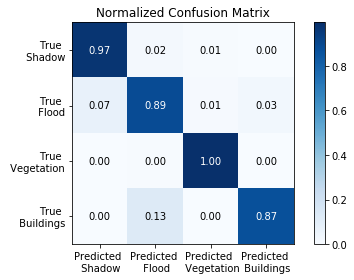

              precision    recall  f1-score   support

           1       0.93      0.97      0.95       190
           2       0.85      0.89      0.87       205
           3       0.99      1.00      0.99       203
           4       0.97      0.87      0.92       222

   micro avg       0.93      0.93      0.93       820
   macro avg       0.93      0.93      0.93       820
weighted avg       0.93      0.93      0.93       820



,Class,Error of Commission,Error of Omission,Producers Accuracy,Users Accuracy
0,Shadow,0.075000,0.026316,0.973684,0.925000
1,Flood,0.153488,0.112195,0.887805,0.846512
2,Vegetation,0.014634,0.004926,0.995074,0.985366
3,Buildings,0.030000,0.126126,0.873874,0.970000


In [17]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(ytest,ypred,cmap=plt.cm.Blues)
cm = confusion_matrix(ytest,ypred)
classes = ("Shadow","Flood","Vegetation","Buildings")
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(ytest, ypred))
conf_summary_stats

Errors of commission represent the fraction of values that were predicted to be in a class but do not belong to that class. They are a measure of false positives. Errors of omission represent the fraction of values that belong to a class but were predicted to be in a different class. They are a measure of false negatives. 

Producer accuracy or recall is the probability that a value in a given class was classified correctly. User's accuracy or precision is the probability that a value predicted to be in a certain class really is that class. The probability is based on the fraction of correctly predicted values to the total number of values predicted to be in a class.

In [ ]:
# Define SVM classifier with rbf kernel
clf_rbf = SVC(kernel='rbf',gamma='scale')
clf_rbf.fit(Xtrain, ytrain.values.ravel())
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest.values.ravel(), ypred_rbf)

0.9378048780487804

In [ ]:
# Commented out to avoid overwriting
# Save out SVM classifier with rbf kernel, accuracy score of 0.9406528189910979
# pickle.dump(clf_rbf, open(combined_svm_outputs_path+'pickle_combined_svm_rbf_final', 'wb'))

[[184   5   1   0]
 [ 15 183   2   5]
 [  0   1 202   0]
 [  0  22   0 200]]

Accuracy score: 0.9378048780487804

Kappa coefficient:  0.9170583685369191


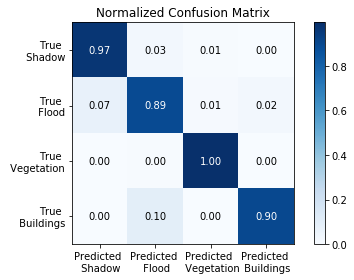

              precision    recall  f1-score   support

           1       0.92      0.97      0.95       190
           2       0.87      0.89      0.88       205
           3       0.99      1.00      0.99       203
           4       0.98      0.90      0.94       222

   micro avg       0.94      0.94      0.94       820
   macro avg       0.94      0.94      0.94       820
weighted avg       0.94      0.94      0.94       820



,Class,Error of Commission,Error of Omission,Producers Accuracy,Users Accuracy
0,Shadow,0.075000,0.026316,0.973684,0.925000
1,Flood,0.153488,0.112195,0.887805,0.846512
2,Vegetation,0.014634,0.004926,0.995074,0.985366
3,Buildings,0.030000,0.126126,0.873874,0.970000


In [ ]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(ytest,ypred_rbf,cmap=plt.cm.Blues)
cm = confusion_matrix(ytest,ypred)
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(ytest, ypred_rbf))
conf_summary_stats

# Validation with 40% of data held back from SVM model development

In [ ]:
# Load saved SVM classifer
loaded_clf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_svm_final_v2', 'rb'))

# Apply linear kernel SVM classifier to external dataset
ypred_valid = clf.predict(Xext)
accuracy_score(yext, ypred_valid)

0.9290416971470373

[[319   9   2   1]
 [ 27 298   0   5]
 [  0   2 344   0]
 [  1  50   0 309]]

Accuracy score: 0.9290416971470373

Kappa coefficient:  0.9054381328240552


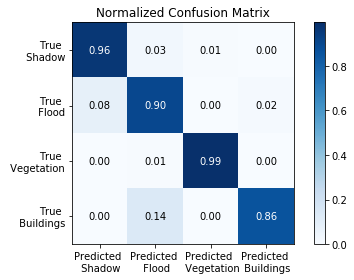

              precision    recall  f1-score   support

           1       0.92      0.96      0.94       331
           2       0.83      0.90      0.87       330
           3       0.99      0.99      0.99       346
           4       0.98      0.86      0.92       360

   micro avg       0.93      0.93      0.93      1367
   macro avg       0.93      0.93      0.93      1367
weighted avg       0.93      0.93      0.93      1367



,Class,Error of Commission,Error of Omission,Producers Accuracy,Users Accuracy
0,Shadow,0.080692,0.036254,0.963746,0.919308
1,Flood,0.169916,0.096970,0.903030,0.830084
2,Vegetation,0.005780,0.005780,0.994220,0.994220
3,Buildings,0.019048,0.141667,0.858333,0.980952


In [ ]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(yext, ypred_valid,cmap=plt.cm.Blues)
cm = confusion_matrix(yext, ypred_valid)
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(yext, ypred_valid))
conf_summary_stats

In [ ]:
# Write out confusion matrix array
confusion_svm_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_svm_external).to_csv(
    combined_svm_outputs_path+'confusion_svm_external_additional_points_v4.csv')

In [ ]:
# Create df with predicted and reference data
# Subset df to focus only on flood, all other reference points (shadow, other) removed
ypred_df = pd.DataFrame(ypred_valid)
yext_df = pd.DataFrame(yext)
external_xy = pd.concat([yext_df, ypred_df], axis=1, sort=False)
external_xy.columns = ['ClassValue', 'ypred_valid']
external_xy.head()
flood_only_accuracy = external_xy[external_xy.ClassValue == 2]


# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy['ClassValue']
ypred_flood_only = flood_only_accuracy['ypred_valid']
print('Accuracy Score: ',accuracy_score(ytest_flood_only, ypred_flood_only))

Accuracy Score:  0.9030303030303031


In [ ]:
# Load saved SVM classifer with rbf kernel
loaded_clf_rbf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_svm_rbf_final', 'rb'))

# Apply rbf kernel SVM classifier to external dataset
ypred_rbf_valid = loaded_clf_rbf.predict(Xext)
accuracy_score(yext, ypred_rbf_valid)

0.9180687637161667

[[315  12   4   0]
 [ 32 292   1   5]
 [  0   2 344   0]
 [  1  54   1 304]]

Accuracy score: 0.9180687637161667

Kappa coefficient:  0.8908241173278493


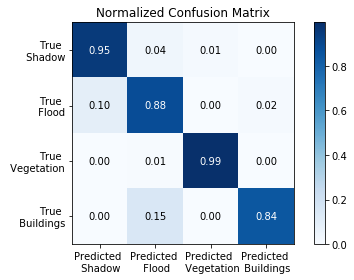

              precision    recall  f1-score   support

           1       0.92      0.96      0.94       331
           2       0.83      0.90      0.87       330
           3       0.99      0.99      0.99       346
           4       0.98      0.86      0.92       360

   micro avg       0.93      0.93      0.93      1367
   macro avg       0.93      0.93      0.93      1367
weighted avg       0.93      0.93      0.93      1367



,Class,Error of Commission,Error of Omission,Producers Accuracy,Users Accuracy
0,Shadow,0.094828,0.048338,0.951662,0.905172
1,Flood,0.188889,0.115152,0.884848,0.811111
2,Vegetation,0.017143,0.005780,0.994220,0.982857
3,Buildings,0.016181,0.155556,0.844444,0.983819


In [ ]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(yext, ypred_rbf_valid,cmap=plt.cm.Blues)
cm = confusion_matrix(yext, ypred_rbf_valid)
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(yext, ypred_valid))
conf_summary_stats

# Plot maps based on trained SVM model with linear kernel

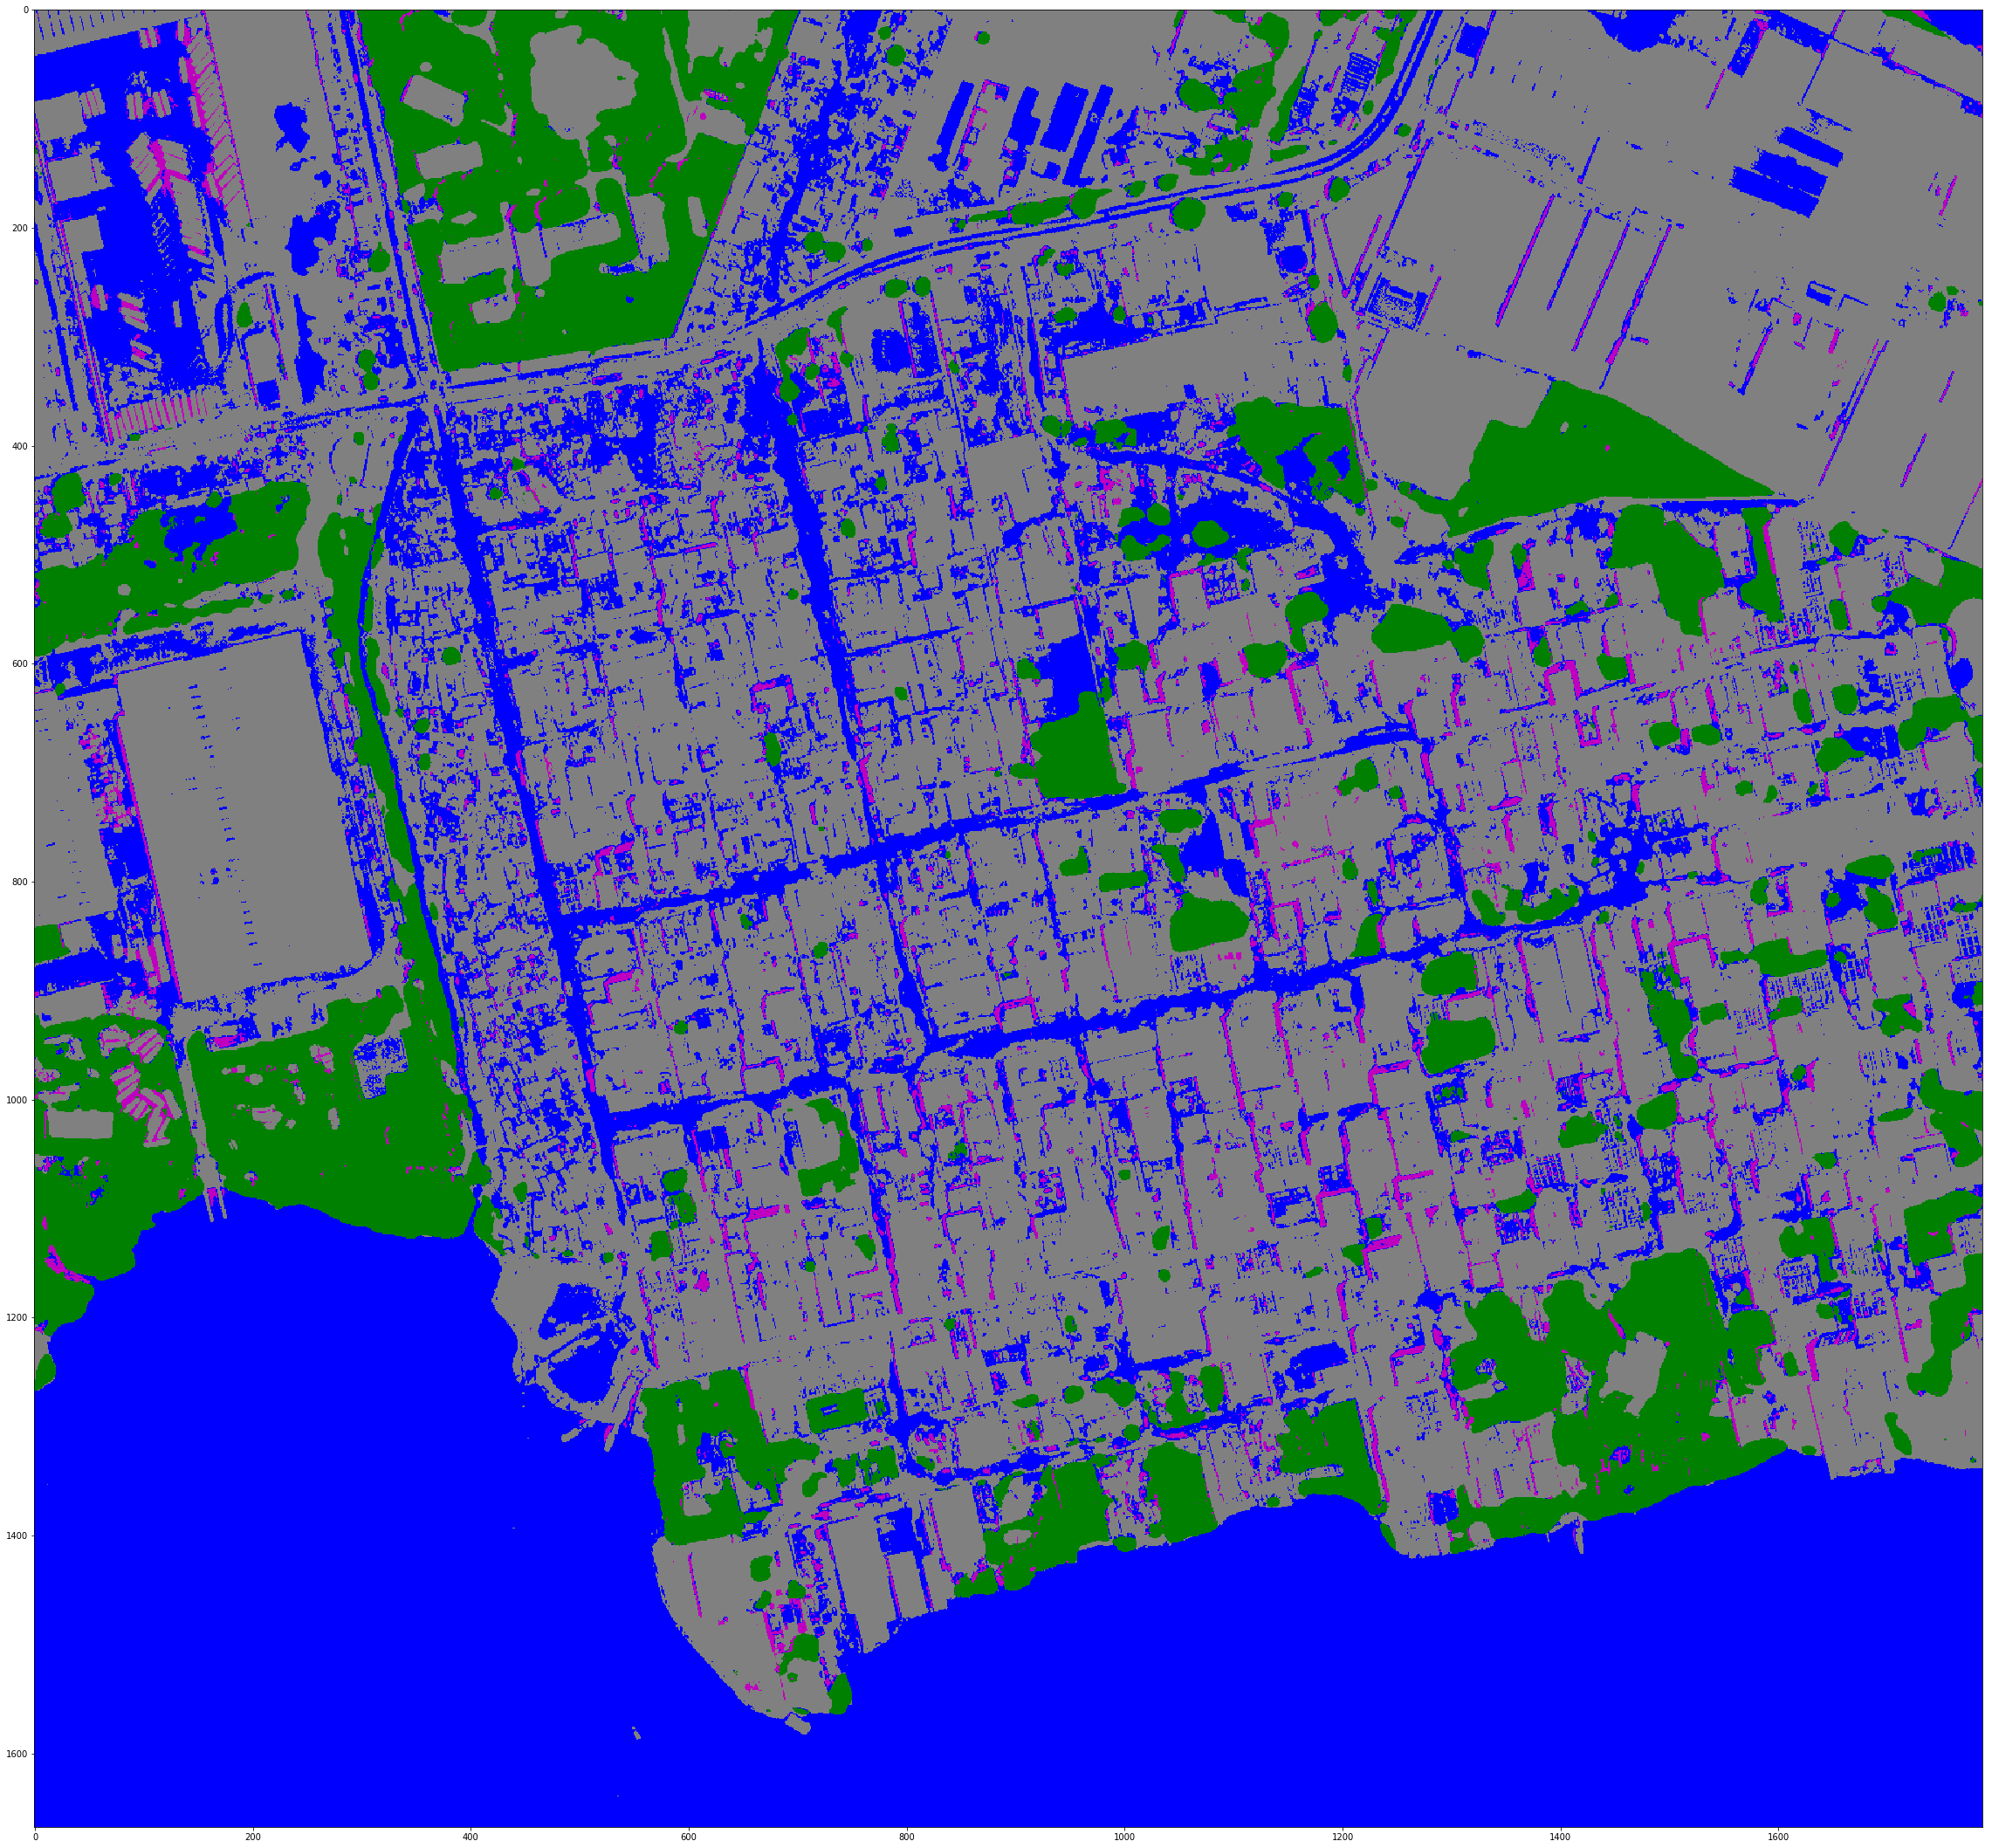

In [ ]:
# Create stack of inputs for entire Koumassi image and apply saved linear SVM classifer
koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3) # Update based on number of model params
X_koumassi_index = koumassi_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_koumassi_index)

# Plot SVM map for Koumassi
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [ ]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'koumassi_SVM_map_combined_final.tif', 
              'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

In [ ]:
# Create stack of inputs for entire Southeast image and apply saved linear SVM classifer
southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3)

# Update based on number of model params
X_southeast_index = southeast_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot SVM map for Southeast
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [ ]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'southeast_SVM_map_combined_final.tif', 
              'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

# Define and apply random forest

In [ ]:
# Define random forest classifier
clf_random_forest = RandomForestClassifier(
    n_estimators=100, max_depth=2, random_state=10)

In [ ]:
# Split training dataset, test size is 40%, training size 60%
# Iterate until accuracy score is satisfactory
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(
    Xint, yint, test_size=0.4)

In [ ]:
# Apply random forest classifier
clf_random_forest.fit(Xtrain_rf, ytrain_rf)
ypred_random_forest = clf_random_forest.predict(Xtest_rf)
accuracy_score(ytest_rf, ypred_random_forest)

In [ ]:
# Commented out to avoid overwriting final classifier
# Save out random forest classfier with accuracy score of 0.9304878048780488
# pickle.dump(clf_random_forest, open(combined_svm_outputs_path+'pickle_combined_RF_final', 'wb'))

In [ ]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(ytest_rf, ypred_random_forest,cmap=plt.cm.Blues)
cm = confusion_matrix(ytest_rf, ypred_random_forest)
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(yext, ypred_valid))
conf_summary_stats

# Validation with 40% of data held back from random forest model development

In [ ]:
# Load saved random forest classifer
loaded_clf_rf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_RF_final', 'rb'))

In [ ]:
# Apply linear kernel random forest classifier to external dataset
ypred_valid_rf = loaded_clf_rf.predict(Xext)
accuracy_score(yext, ypred_valid_rf)

In [ ]:
# Print confusion matrix, kappa coefficient and table with error and accuracy values
confusion_matrix_plus.plot_conf_matrix(yext, ypred_valid_rf,cmap=plt.cm.Blues)
cm = confusion_matrix(yext, ypred_valid_rf)
conf_summary_stats = confusion_matrix_plus.oc_error_up_accuracy(cm,classes)
print(classification_report(yext, ypred_valid))
conf_summary_stats

In [ ]:
# Write out confusion matrix
confusion_rf_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_rf_external).to_csv(
    combined_svm_outputs_path+'confusion_rf_external_final.csv')

In [ ]:
# Create df with predicted and reference data
# Subset df to focus only on flood, all other reference points (shadow, other) removed
ypred_rf_df = pd.DataFrame(ypred_valid_rf)
yext_df = pd.DataFrame(yext)
external_xy_rf = pd.concat([yext_df, ypred_rf_df], axis=1, sort=False)
external_xy_rf.columns = ['ClassValue', 'ypred_valid_rf']
external_xy_rf.head()
flood_only_accuracy_rf = external_xy_rf[external_xy_rf.ClassValue == 2]

# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy_rf['ClassValue']
ypred_flood_only = flood_only_accuracy_rf['ypred_valid_rf']
print("Accuracy score:",accuracy_score(ytest_flood_only, ypred_flood_only))

# Plot maps based on trained random forest model

In [ ]:
# Create stack of inputs for entire image and apply saved random forest classifer
# koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3)# Update based on number of model params
X_koumassi_index = koumassi_index_im.reshape(-1, 8)
predictedClass = loaded_clf_rf.predict(X_koumassi_index)

# Plot random forest map for Koumassi
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [ ]:
# Write out random forest tif for Koumassi
with rio.open(combined_svm_outputs_path+'koumassi_RF_map_combined_final.tif', 
              'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

In [ ]:
# Create stack of inputs for entire image and apply saved random forest classifer
# southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3) # Update based on number of model params
X_southeast_index = southeast_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot random forest map for southeast
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [ ]:
# Write out random forest tif for Southeast
with rio.open(combined_svm_outputs_path+'southeast_RF_map_combined_final.tif', 
              'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)